In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import pmdarima.arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [3]:
df = pd.read_csv('Impute_misvalues_hungyen.csv')
df['Hour'] = df['Hour'].replace('#NUM!', 0)
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], axis = 1, inplace = True)

df.head()

,Waterlevel
DateTime,
2008-01-01 00:00:00,47.0
2008-01-01 01:00:00,43.0
2008-01-01 02:00:00,40.0
2008-01-01 03:00:00,37.0
2008-01-01 04:00:00,34.0


In [4]:
train_size = int(len(df) * 0.7)
train, test = df[:train_size].iloc[:, [-1]], df[train_size:].iloc[:, [-1]]

train, test

(                     Waterlevel
 DateTime                       
 2008-01-01 00:00:00        47.0
 2008-01-01 01:00:00        43.0
 2008-01-01 02:00:00        40.0
 2008-01-01 03:00:00        37.0
 2008-01-01 04:00:00        34.0
 ...                         ...
 2013-02-11 05:00:00        86.0
 2013-02-11 06:00:00       100.0
 2013-02-11 07:00:00       115.0
 2013-02-11 08:00:00       128.0
 2013-02-11 09:00:00       134.0
 
 [44842 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2013-02-11 10:00:00       133.0
 2013-02-11 11:00:00       127.0
 2013-02-11 12:00:00       122.0
 2013-02-11 13:00:00       115.0
 2013-02-11 14:00:00       107.0
 ...                         ...
 2015-04-23 00:00:00       127.0
 2015-04-23 01:00:00       124.0
 2015-04-23 02:00:00       120.0
 2015-04-23 03:00:00       115.0
 2015-04-23 04:00:00       109.0
 
 [19219 rows x 1 columns])

In [5]:
scaler = MinMaxScaler()
train['Waterlevel'] = scaler.fit_transform(train)
test['Waterlevel'] = scaler.transform(test)

In [6]:
train_data = train.values
test_data = test.values
train_data.shape

(44842, 1)

In [7]:
timesteps = 164


In [8]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


In [9]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

x_train, y_train

(array([[0.10782866, 0.10192024, 0.09748892, ..., 0.17282127, 0.16395864,
         0.15509601],
        [0.10192024, 0.09748892, 0.09305761, ..., 0.16395864, 0.15509601,
         0.14623338],
        [0.09748892, 0.09305761, 0.08862629, ..., 0.15509601, 0.14623338,
         0.13737075],
        ...,
        [0.1816839 , 0.17725258, 0.17282127, ..., 0.14327917, 0.16543575,
         0.18611521],
        [0.17725258, 0.17282127, 0.16838996, ..., 0.16543575, 0.18611521,
         0.20827179],
        [0.17282127, 0.16838996, 0.16395864, ..., 0.18611521, 0.20827179,
         0.22747415]]),
 array([[0.14623338],
        [0.13737075],
        [0.12998523],
        ...,
        [0.20827179],
        [0.22747415],
        [0.23633678]]))

In [10]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r2 = r2_score(y_true, y_pred)
    
    r, _ = pearsonr(y_true, y_pred)
    
    sim, _ = pearsonr(y_true, y_pred)
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R': r,
        'SIM': sim,
        'FSD': fsd,
        'NSE': nse
    }


In [11]:
train_ARIMA = scaler.inverse_transform(train_data)
test_ARIMA = scaler.inverse_transform(test_data)
train_ARIMA.shape
test_ARIMA.shape

(19219, 1)

In [15]:
warnings.filterwarnings(category=UserWarning, action='ignore')
arima_model = pmdarima.arima.auto_arima(train_ARIMA, seasonal=False, 
                                        error_action='ignore', trace=True,
                                        suppress_warnings=True, maxiter=20, stepwise=True,
                                        n_jobs=2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=200980.726, Time=13.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=289610.714, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=216400.279, Time=1.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=248451.402, Time=4.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=289608.719, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=207092.816, Time=5.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=201845.967, Time=12.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=201859.951, Time=14.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=200607.340, Time=17.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=206436.578, Time=8.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=200572.517, Time=17.93 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=200280.772, Time=22.82 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=20.78 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=200378.544, Time=23.19 sec
 ARI

In [73]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_ARIMA, order=(5,1,3))  # Replace p, d, q with appropriate ARIMA parameters
fitted_model = model.fit()

# Extract residuals
residuals = fitted_model.resid

In [74]:
residuals

array([47.        , -4.00114987,  0.47909232, ...,  3.22766243,
        0.31093354, -3.64911002])

In [75]:
arima_model.fit(train_ARIMA)
predictions_arima = arima_model.predict(len(test_data))
predictions_arima

array([135.96263265, 134.36120291, 130.62252551, ...,  97.25575895,
        97.25575895,  97.25575895])

In [76]:
# arima_model.fit(train_ARIMA)
pred = arima_model.predict(len(train_data)+len(test_data))

In [77]:
residuals_test = test_ARIMA.flatten() - predictions_arima

In [78]:
residuals_test

array([-2.96263265, -7.36120291, -8.62252551, ..., 22.74424105,
       17.74424105, 11.74424105])

In [79]:
train_res=np.array([[j for j in residuals.reshape(-1,1)[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_res=np.array([[j for j in residuals_test.reshape(-1,1)[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]

In [80]:
x_train, y_train = train_res[:,:timesteps-1],train_res[:,[timesteps-1]]
x_test, y_test = test_res[:,:timesteps-1],test_res[:,[timesteps-1]]

x_train, y_train

(array([[47.        , -4.00114987,  0.47909232, ..., -0.26702778,
         -0.71641466, -0.84493908],
        [-4.00114987,  0.47909232, -0.95816842, ..., -0.71641466,
         -0.84493908, -1.23877348],
        [ 0.47909232, -0.95816842, -0.83765709, ..., -0.84493908,
         -1.23877348, -1.54289072],
        ...,
        [-0.19013348,  0.55459315, -0.38032854, ...,  1.97312746,
         -2.21156434,  0.43293278],
        [ 0.55459315, -0.38032854, -0.53123035, ..., -2.21156434,
          0.43293278,  3.22766243],
        [-0.38032854, -0.53123035, -0.88352744, ...,  0.43293278,
          3.22766243,  0.31093354]]),
 array([[-1.23877348],
        [-1.54289072],
        [-0.94525958],
        ...,
        [ 3.22766243],
        [ 0.31093354],
        [-3.64911002]]))

In [81]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r, _ = pearsonr(y_true, y_pred)
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R': r,
        'SIM': sim,
        'FSD': fsd,
        'NSE': nse
    }

In [82]:
model_RF = RandomForestRegressor(n_estimators=100, max_features=6, random_state=42)

model_RF.fit(x_train, y_train[:,0])

RandomForestRegressor(max_features=6, random_state=42)

In [83]:
hours = 120
def forecast_value (model, hours):
    current_window = x_train[-1,:].tolist()

    predict = []

    for _ in range(hours):
        next_value = model.predict([current_window])[0]
        predict.append(next_value)
        
        current_window.pop(0)  
        current_window.append(next_value)
    predict_array = np.array(predict).reshape(-1, 1)
    return(predict_array)
predict_RF = forecast_value(model_RF, hours)    

In [84]:
predict_RF

array([[-2.55773476],
       [-0.56157432],
       [-0.82790719],
       [ 0.05984405],
       [ 0.3878934 ],
       [ 0.22226805],
       [ 0.09107113],
       [-0.11127376],
       [ 0.16683646],
       [-0.34084162],
       [-0.18619347],
       [-0.82813063],
       [-1.00717664],
       [-1.06634221],
       [-1.50141583],
       [-1.73985147],
       [-1.7396445 ],
       [ 0.18026165],
       [ 2.16441918],
       [ 2.91688643],
       [ 0.37341808],
       [-0.72615142],
       [ 0.05152995],
       [ 0.33738377],
       [ 0.05547783],
       [-0.55695842],
       [-1.09048682],
       [-0.69536345],
       [-0.03342866],
       [ 0.28823781],
       [ 0.2497247 ],
       [ 0.23022544],
       [ 0.02628269],
       [-0.0992102 ],
       [-0.36743712],
       [-0.20666555],
       [-0.69684048],
       [-0.89265332],
       [-0.95637393],
       [-1.29929265],
       [-1.36142782],
       [-1.07872935],
       [ 0.18233015],
       [ 1.64498248],
       [ 1.73018059],
       [ 0

In [85]:
predict_ARIMA_RF = predictions_arima[:120] + predict_RF.flatten()
predict_ARIMA_RF

array([133.40489789, 133.79962859, 129.79461831, 125.41295154,
       119.00466861, 111.00629423, 102.74727458,  94.90371571,
        88.50976466,  82.57723528,  78.78388405,  75.84665681,
        75.06042196,  75.95500177,  77.79857948,  80.87405784,
        84.90094921,  91.21420721,  97.61151273, 102.48101861,
       103.49748081, 105.20569529, 107.91412291, 109.20088841,
       109.0078237 , 107.65318199, 105.6783466 , 104.10120511,
       102.44907799, 100.31010043,  97.85140635,  95.61854521,
        93.54391002,  91.98914337,  90.79137667,  90.53998811,
        90.13461788,  90.46715458,  91.29582268,  92.11183283,
        93.36824483,  95.02117359,  97.60288103, 100.24848858,
       101.30893397, 100.3705744 , 100.94516891, 100.83914261,
       100.3281281 , 100.49785497,  99.29104115,  98.4950253 ,
        98.08668249,  97.72667257,  97.10771041,  96.60589591,
        96.00440549,  95.69157954,  95.35787303,  95.26537516,
        95.0448403 ,  95.19766307,  95.08675861,  95.37

In [86]:
metrics_ARIMA = calculate_metrics(test_ARIMA[:hours].flatten(), predict_ARIMA_RF[:hours].flatten())
for metric, value in metrics_ARIMA.items():
    print(f'{metric}: {value}')

MAE: 41.02600946025687
RMSE: 47.642561282121406
R: 0.6005526644987743
SIM: 0.7666509040512747
FSD: 1.5655353117783823
NSE: -1.6977968161021697


In [87]:
scaler = MinMaxScaler()
res_train_tf = scaler.fit_transform(residuals.reshape(-1, 1))
res_test_tf = scaler.transform(residuals_test.reshape(-1, 1))


In [88]:
train_res_tf=np.array([[j for j in res_train_tf[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_res_tf=np.array([[j for j in res_test_tf[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]

In [89]:
x_train_tf, y_train_tf = train_res_tf[:,:timesteps-1],train_res_tf[:,[timesteps-1]]
x_test_tf, y_test_tf = test_res_tf[:,:timesteps-1],test_res_tf[:,[timesteps-1]]



In [90]:
x_train.shape , y_train.shape

((44679, 163), (44679, 1))

In [91]:
model_SVR = SVR(kernel='rbf',gamma=0.001, C=50, epsilon = 0.005)
model_SVR.fit(x_train_tf, y_train_tf[:,0])

SVR(C=50, epsilon=0.005, gamma=0.001)

In [92]:
def forecast_value_tf (model, hours):
    current_window = x_train_tf[-1,:].tolist()

    predict = []

    for _ in range(hours):
        next_value = model.predict([current_window])[0]
        predict.append(next_value)
        
        current_window.pop(0)  
        current_window.append(next_value)
    predict_array = np.array(predict).reshape(-1, 1)
    return(predict_array)
predict_RF = forecast_value(model_RF, hours) 

In [93]:
hours = 120
predict_SVR = forecast_value_tf (model_SVR, hours) 
predict_SVR

array([[0.25292269],
       [0.247812  ],
       [0.24612003],
       [0.27686794],
       [0.28389677],
       [0.28143626],
       [0.27510653],
       [0.27458082],
       [0.28102767],
       [0.27319805],
       [0.26844331],
       [0.26851828],
       [0.2643802 ],
       [0.26115804],
       [0.25217678],
       [0.23941623],
       [0.22840658],
       [0.25604161],
       [0.29947896],
       [0.32216547],
       [0.29270236],
       [0.27510378],
       [0.28378207],
       [0.29613837],
       [0.27942697],
       [0.26410505],
       [0.24471015],
       [0.25454947],
       [0.26968021],
       [0.28115973],
       [0.27630948],
       [0.27091239],
       [0.27328158],
       [0.27543425],
       [0.2736707 ],
       [0.26608038],
       [0.26517173],
       [0.26646771],
       [0.26241203],
       [0.25271329],
       [0.24014654],
       [0.24365836],
       [0.26251056],
       [0.29221792],
       [0.30221215],
       [0.29079741],
       [0.27938783],
       [0.284

In [94]:
predict_SVR = scaler.inverse_transform(predict_SVR)

In [95]:
predict_ARIMA_SVR = predictions_arima[:120] + predict_SVR.flatten()
predict_ARIMA_SVR


array([134.65241013, 132.72049464, 128.87240488, 125.59131965,
       119.30951116, 111.31765151, 102.78051309,  95.10530339,
        88.85013177,  82.91897287,  78.66350533,  76.37306336,
        75.49828338,  76.24366571,  77.94153782,  80.43028328,
        83.74502117,  89.92541008,  97.14746152, 102.73153706,
       104.38621746, 106.05597843, 108.54791165, 110.34785103,
       109.35603942, 107.623032  , 104.92754175, 103.59154244,
       102.25591952, 100.53760588,  97.80378028,  95.2414122 ,
        93.52392511,  92.23385499,  91.19027447,  90.2872811 ,
        90.31332742,  90.92548244,  91.55560791,  92.087362  ,
        92.59327209,  94.19059662,  96.7303341 ,  99.83433388,
       101.45586439, 101.43653592, 101.13506002, 101.63276585,
       101.73658334, 100.93943662,  99.2180066 ,  97.87950855,
        97.61286725,  97.6043359 ,  97.33917908,  96.48745739,
        95.89375238,  95.58972604,  95.42615406,  95.19639548,
        95.03629531,  95.28839053,  95.59044773,  95.55

In [96]:
metrics_ARIMA = calculate_metrics(test_ARIMA[:hours].flatten(), predict_ARIMA_SVR[:hours].flatten())
for metric, value in metrics_ARIMA.items():
    print(f'{metric}: {value}')

MAE: 41.09479240802478
RMSE: 47.621479600251234
R: 0.6110913798313643
SIM: 0.7661285811962627
FSD: 1.5642280747769994
NSE: -1.695409811315093


In [97]:
knn_regressor = KNeighborsRegressor(n_neighbors=6)
knn_regressor.fit(x_train_tf, y_train_tf[:,0])

KNeighborsRegressor(n_neighbors=6)

In [98]:
predict_KNN = forecast_value_tf(knn_regressor, hours)

In [99]:
predict_KNN = scaler.inverse_transform(predict_KNN)

In [100]:
predict_KNN

array([[-8.52053296e-01],
       [-1.21334548e+00],
       [-8.20781497e-01],
       [ 6.72373012e-01],
       [-3.27707276e-01],
       [ 9.09341209e-01],
       [ 3.49640090e-01],
       [-1.96987965e-01],
       [ 5.64907306e-01],
       [-2.43071572e-01],
       [-6.94574029e-01],
       [-3.85644116e-01],
       [-9.57084897e-01],
       [-1.18952263e+00],
       [-3.10345710e-01],
       [-8.04042076e-01],
       [-1.97186891e+00],
       [-4.79631314e-01],
       [ 2.42329956e+00],
       [ 3.82533929e+00],
       [ 8.86688608e-01],
       [-6.25107201e-01],
       [-6.44420427e-01],
       [-4.90891188e-01],
       [-5.63055251e-02],
       [-1.04025499e+00],
       [-1.80059917e-01],
       [-1.65036074e-01],
       [ 5.01077466e-01],
       [ 1.85693530e+00],
       [ 1.23039012e+00],
       [ 5.47259417e-03],
       [-1.99027194e-02],
       [ 3.01120365e-01],
       [-7.19881479e-01],
       [-3.68406826e-01],
       [-1.60184060e-01],
       [-3.81471770e-01],
       [-8.0

In [101]:
predict_ARIMA_KNN = predictions_arima[:120] + predict_KNN.flatten()
predict_ARIMA_KNN

array([135.11057935, 133.14785743, 129.80174401, 126.0254805 ,
       118.28906793, 111.69336738, 103.00584354,  94.81800151,
        88.90783551,  82.67500532,  78.27550349,  76.28914333,
        75.1105137 ,  75.83182135,  78.9896496 ,  81.80986723,
        84.66872479,  90.55431425,  97.87039311, 103.38947146,
       104.01075134, 105.30673951, 107.21817253, 108.37261345,
       108.89604035, 107.16988542, 106.5887735 , 104.63153249,
       102.98358412, 101.87879792,  98.83207176,  95.39379236,
        93.49772461,  92.38947394,  90.43893231,  90.37824683,
        90.6712743 ,  90.97833613,  91.44880872,  91.9171303 ,
        94.0796896 ,  95.61602529,  97.71993108, 100.79573874,
       101.10457172,  99.81293679, 100.32035617,  98.97231004,
       100.39395866,  99.74272017,  99.08187981,  99.57864874,
        98.44675601,  98.45794254,  97.89901853,  96.05931901,
        96.22253059,  95.25218127,  95.03079587,  94.80024666,
        94.91876061,  95.01336111,  94.86195614,  95.66

In [102]:
metrics_ARIMA = calculate_metrics(test_ARIMA[:hours].flatten(), predict_ARIMA_KNN[:hours].flatten())
for metric, value in metrics_ARIMA.items():
    print(f'{metric}: {value}')

MAE: 41.02933165047295
RMSE: 47.683751274741084
R: 0.5985052092476948
SIM: 0.7667073710156149
FSD: 1.5646317700132224
NSE: -1.7024636628893268


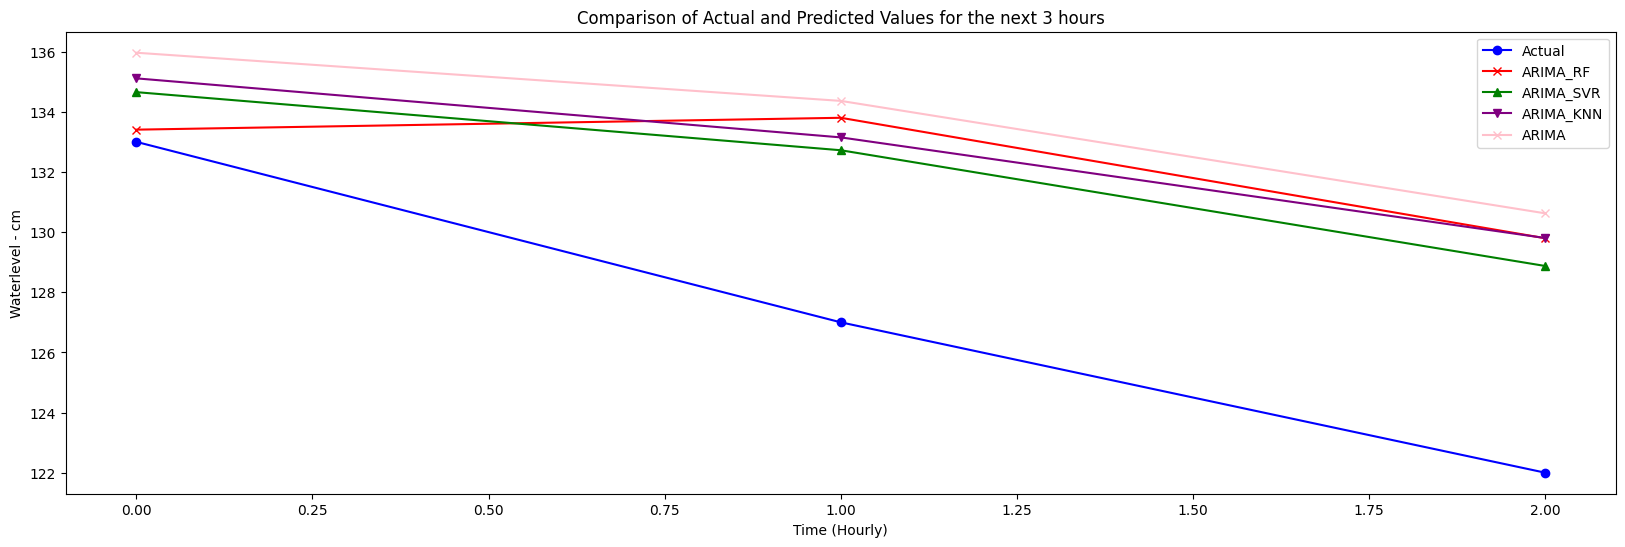

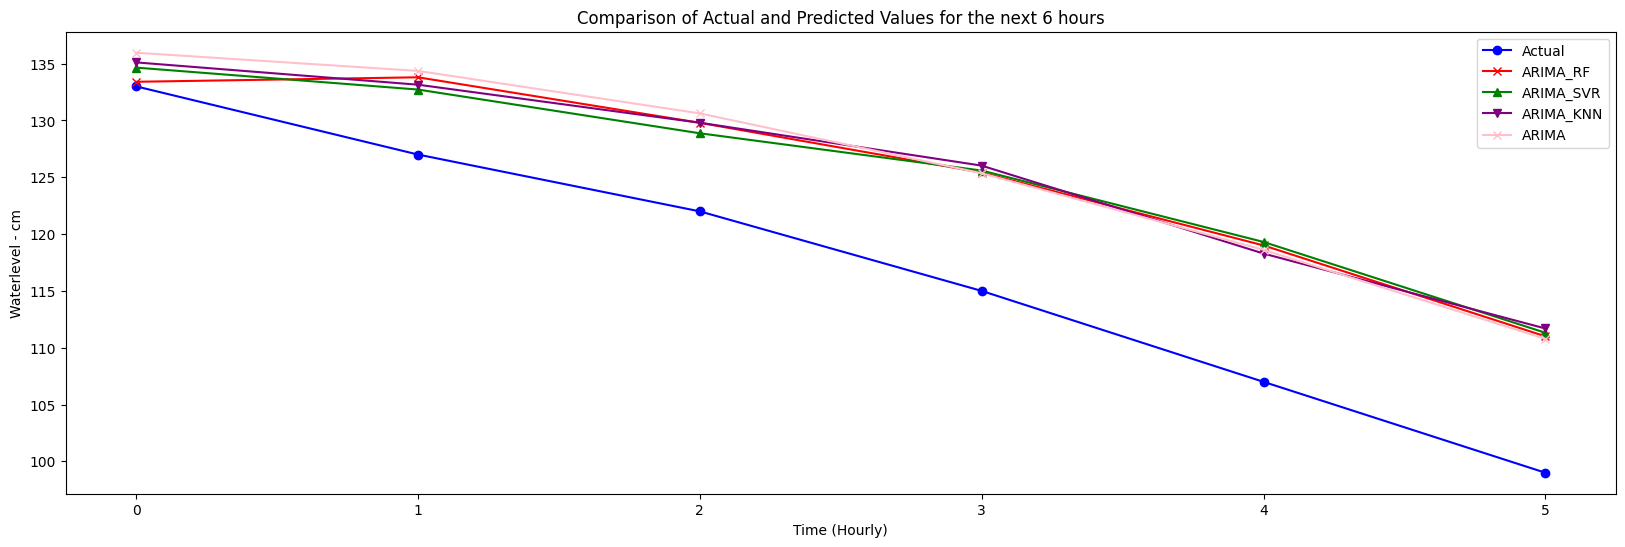

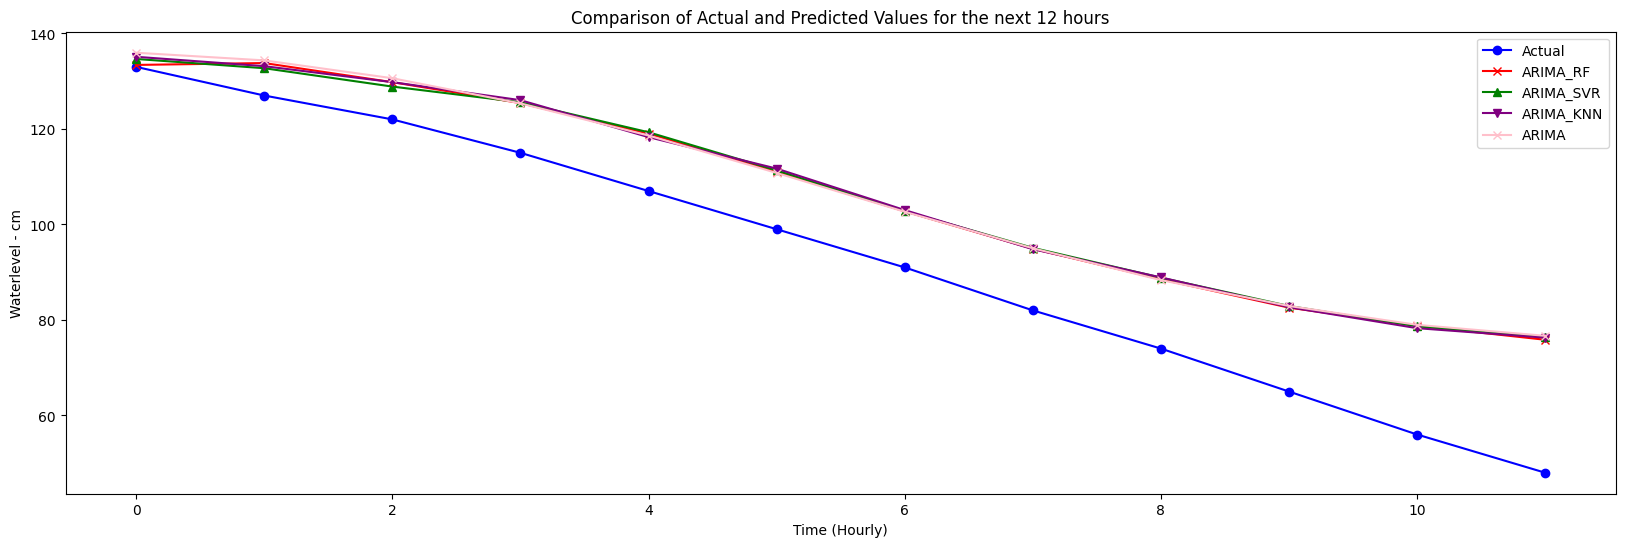

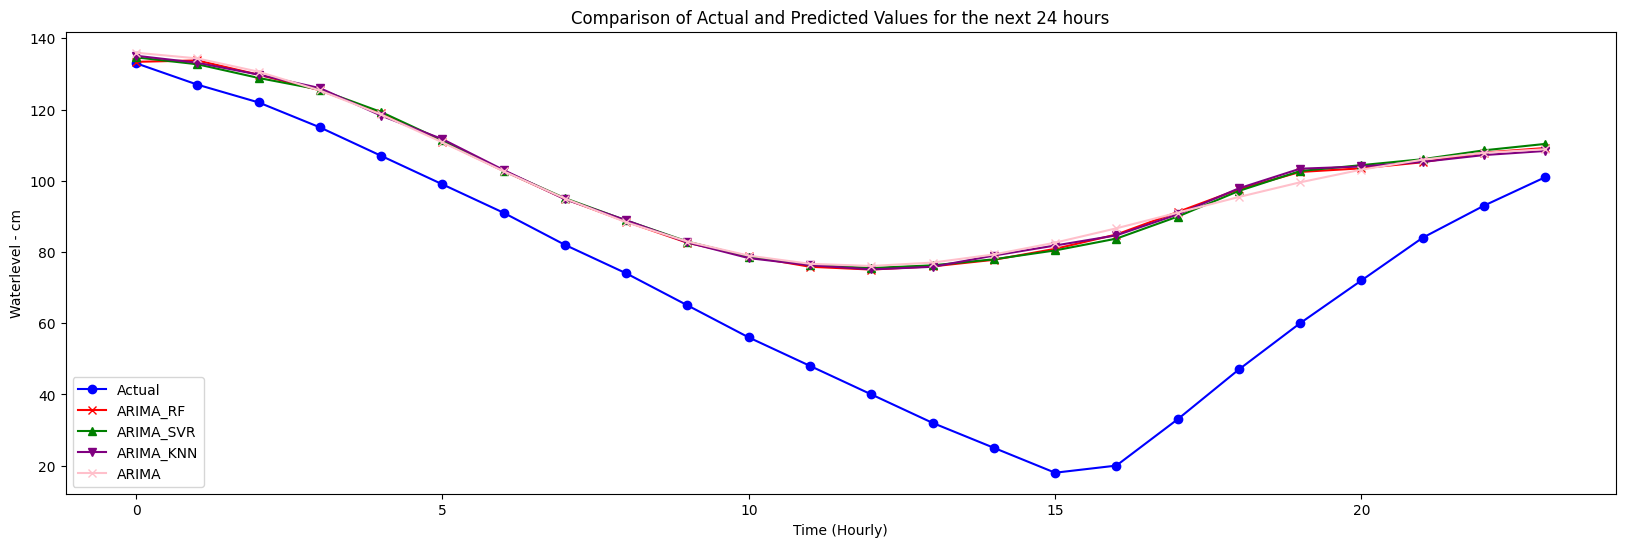

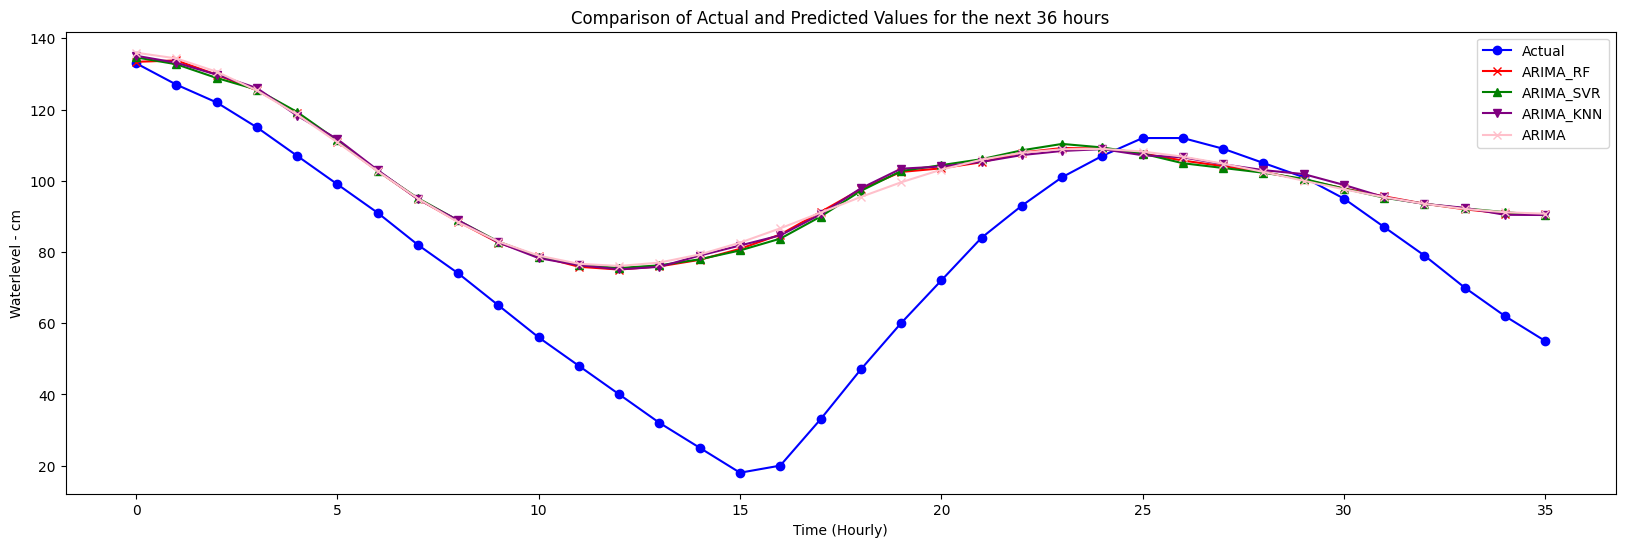

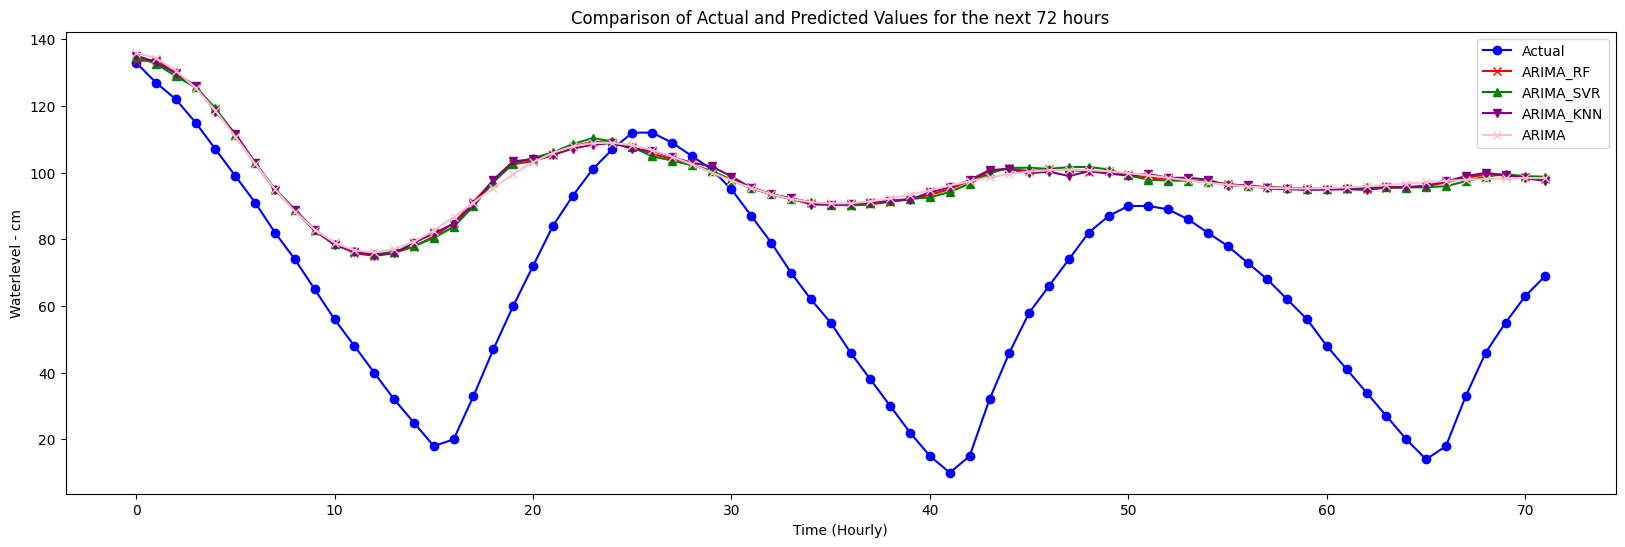

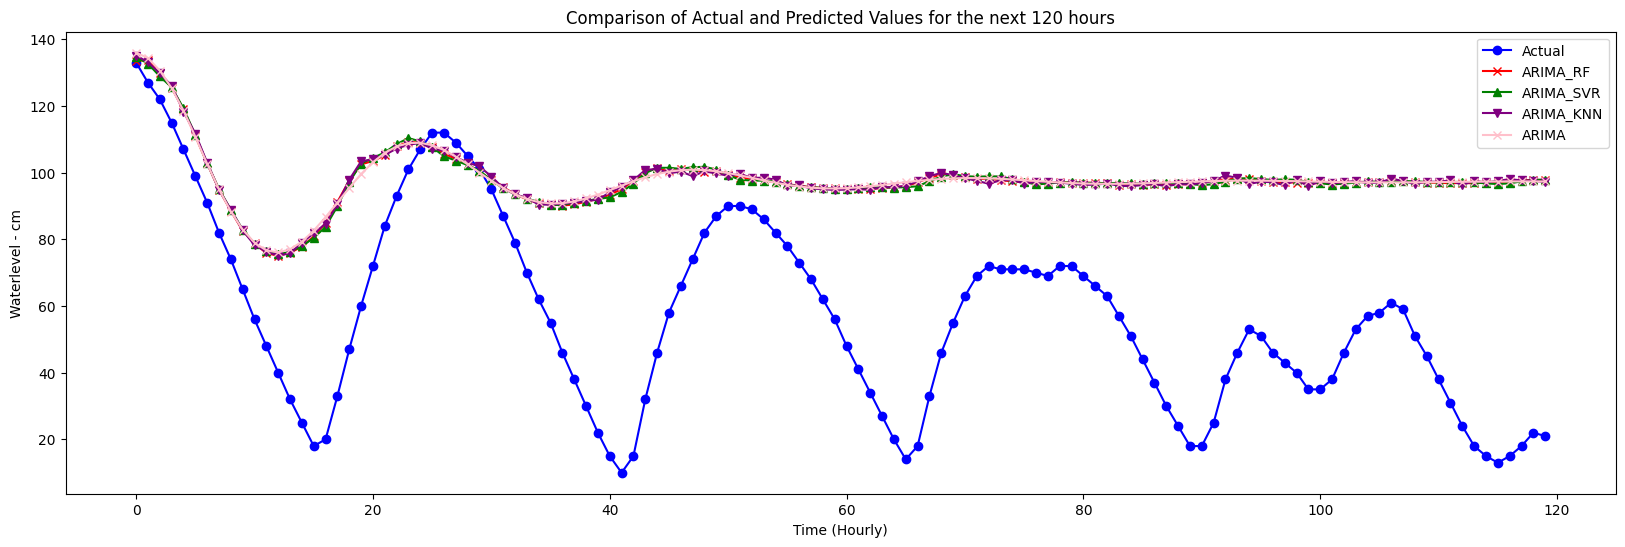

In [103]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(test_ARIMA[:hours], label='Actual', color='blue', marker='o')
    plt.plot(predict_ARIMA_RF.flatten()[:hours], label='ARIMA_RF', color='red', marker='x')
    plt.plot(predict_ARIMA_SVR.flatten()[:hours], label='ARIMA_SVR', color='green', marker='^')
    plt.plot(predict_ARIMA_KNN.flatten()[:hours], label='ARIMA_KNN', color='purple', marker='v')
    plt.plot(predictions_arima.flatten()[:hours], label='ARIMA', color='pink', marker='x')
    
    plt.title(f'Comparison of Actual and Predicted Values for the next {hours} hours')
    plt.xlabel('Time (Hourly)')
    plt.ylabel('Waterlevel - cm')
    plt.legend()

    plt.show()